In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from scipy import stats

import tensorflow


Using TensorFlow backend.


In [2]:
K.set_learning_phase(0)
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [4]:
## get activations for set

In [246]:
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

bottleneck = 'mixed9'
concepts = 'random500_0'
target_class = 'zebra'

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)
acts = act_generator.process_and_load_activations([bottleneck], [concepts] + [target_class])

In [15]:
## comparing activations

In [33]:
## from act gen
xx = acts['noise_black']['mixed9'][0].reshape(-1)
xx[:20]

array([0.        , 0.        , 1.9132142 , 0.51159245, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.71297634, 0.        ],
      dtype=float32)

In [45]:
xx.shape

(131072,)

In [17]:
path = 'activations/images_used_noise_black.pkl'
black_images = pickle.load(open(path, 'rb'))

In [18]:
black_images

['/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/noise_black/img1.jpg',
 '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/concepts/noise_black/img10.jpg']

In [34]:
#img_path = 'concepts/striped_sub_1/striped_0004.jpg'
img_path = black_images[0]
img = prep2(img_path)
acts_orig = get_acts(np.expand_dims(img, axis=0))

In [ ]:
acts_orig[:20]

In [201]:
concept = 'random500_0'
concept_dir = os.path.join(working_dir,'concepts/'+concept)
concept_image_list = files_from_dir(concept_dir)
concept_image_list.sort()

In [254]:
n = 131072

activations = np.zeros((len(concept_image_list),n))
for idx,image_path in enumerate(concept_image_list):
    img = prep2(os.path.join(concept_dir,image_path))
    acts_orig = get_acts(np.expand_dims(img, axis=0))
    activations[idx] = acts_orig

In [255]:
activations.shape

(50, 131072)

In [161]:
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

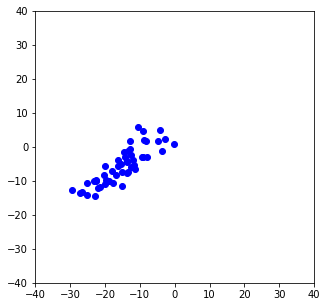

In [210]:
light_blue, light_red = '#b3b8fb', '#f6889f'

embed_pca = np.dot(pca_components, activations.T)

fig = plt.figure(figsize=[5,5])

plt.scatter(embed_pca[0], embed_pca[1], color = 'b')

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

In [215]:
to_load_path

'/Users/tyler/Desktop/dissertation/programming/tcav_on_azure/activations/acts_random500_0_mixed9'

In [313]:
## load and plot activation
concept = 'random500_7'
layer = 'mixed9'

to_load_path = os.path.join(working_dir,f'activations/acts_{concept}_{layer}')

with open(to_load_path, 'rb') as f:
    activations_raw = np.load(f)
activations = activations_raw.reshape((activations_raw.shape[0], 131072))

In [314]:
random_spreads[concept] - 52.736

1.3499350139167419

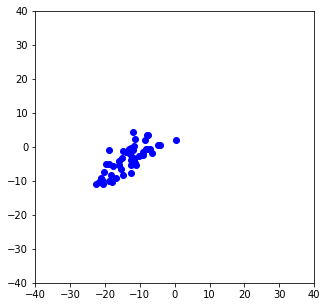

In [315]:
light_blue, light_red = '#b3b8fb', '#f6889f'

embed_pca = np.dot(pca_components, activations.T)

fig = plt.figure(figsize=[5,5])

plt.scatter(embed_pca[0], embed_pca[1], color = 'b')

my_xlim = plt.xlim([-40,40])
my_ylim = plt.ylim([-40,40])

In [163]:
## density measurement

In [285]:
find_spread(activations)

53.09843844175339

In [190]:
## loop through some random classes
random_spreads = pickle.load(open('random_spreads.pkl', 'rb'))

for random_idx in range(20):
    concept = 'random500_' + str(random_idx)
    if concept not in random_spreads:
        concept_dir = os.path.join(working_dir,'concepts/'+concept)
        concept_image_list = files_from_dir(concept_dir)
        concept_image_list.sort()

        n = 131072
        activations = np.zeros((len(concept_image_list),n))
        for idx,image_path in enumerate(concept_image_list):
            img = prep2(os.path.join(concept_dir,image_path))
            acts_orig = get_acts(np.expand_dims(img, axis=0))
            activations[idx] = acts_orig

        spread = find_spread(activations)
        random_spreads[concept] = spread
        print(f'did {concept}')
    else:
        print(f'{concept} already in dict')
pickle.dump(random_spreads,open('random_spreads.pkl', 'wb'))

random500_0 already in dict
random500_1 already in dict
random500_2 already in dict
random500_3 already in dict
random500_4 already in dict
random500_5 already in dict
random500_6 already in dict
random500_7 already in dict
random500_8 already in dict
random500_9 already in dict
random500_10 already in dict
random500_11 already in dict
random500_12 already in dict
random500_13 already in dict
random500_14 already in dict
did random500_15
did random500_16
did random500_17
did random500_18
did random500_19


In [288]:
nums = np.array([num for key,num in list(random_spreads.items())])

In [292]:
nums.mean()

52.73647674121937

In [193]:
nums - nums.min()

array([1.27019012, 0.5900664 , 0.23630781, 1.26083077, 1.45339113,
       0.92814446, 1.3578987 , 2.40624947, 1.42983436, 1.41875215,
       1.02947718, 0.        , 0.41647292, 0.69903042, 1.45437343,
       1.86425961, 0.0984502 , 1.18320903, 1.26875642, 0.77012941])

In [312]:
nums.argmax(),nums.max()

(7, 54.08593501391674)

In [194]:
nums.shape

(20,)

In [199]:
## loop through some random classes
random_spreads_8 = {}#pickle.load(open('random_spreads.pkl', 'rb'))

for random_idx in range(20):
    concept = 'random500_' + str(random_idx)
    if concept not in random_spreads_8:
        concept_dir = os.path.join(working_dir,'concepts/'+concept)
        concept_image_list = files_from_dir(concept_dir)
        concept_image_list.sort()

        n = 81920
        activations = np.zeros((len(concept_image_list),n))
        for idx,image_path in enumerate(concept_image_list):
            img = prep2(os.path.join(concept_dir,image_path))
            acts_orig = get_acts(np.expand_dims(img, axis=0))
            activations[idx] = acts_orig

        spread = find_spread(activations)
        random_spreads_8[concept] = spread
        print(f'did {concept}')
    else:
        print(f'{concept} already in dict')
        
pickle.dump(random_spreads_8,open('random_spreads_8.pkl', 'wb'))

did random500_0
did random500_1
did random500_2
did random500_3
did random500_4
did random500_5
did random500_6
did random500_7
did random500_8
did random500_9
did random500_10
did random500_11
did random500_12
did random500_13
did random500_14
did random500_15
did random500_16
did random500_17
did random500_18
did random500_19


In [200]:
random_spreads_8

{'random500_0': 44.07051621018231,
 'random500_1': 43.7502458008406,
 'random500_2': 43.53175545638695,
 'random500_3': 43.57965343288536,
 'random500_4': 43.6746302193161,
 'random500_5': 43.85996110985862,
 'random500_6': 42.75156035144748,
 'random500_7': 44.93422508294089,
 'random500_8': 44.260604353968084,
 'random500_9': 44.25572438117097,
 'random500_10': 43.41187580115229,
 'random500_11': 43.25582216453428,
 'random500_12': 43.564594107222135,
 'random500_13': 43.59572252677634,
 'random500_14': 44.474973132945394,
 'random500_15': 43.89064643810843,
 'random500_16': 42.867428282542626,
 'random500_17': 43.841153807855406,
 'random500_18': 43.75226858065455,
 'random500_19': 42.87818403827258}

In [157]:
def find_spread(activations):
    means = activations.mean(axis=0)
    d = 0
    for i in range(activations.shape[0]):
        d += euclidean_distance(vec_norm(activations[i]),vec_norm(means))
    return d



In [98]:
#euclidean_distance

In [94]:
black_activations.var()

0.04355347506021248

In [86]:
black_activations.mean()

0.05023052116018789

In [87]:
black_activations.var()

0.04364542695071567

In [79]:
black_activations.mean()

0.05079675302872261

In [96]:
black_activations.var(axis=0)

array([0.        , 0.        , 0.21405371, ..., 0.10952863, 0.        ,
       0.09491275])

In [ ]:
## resulting CAVS

In [ ]:
## resulting TCAV

In [207]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'

these_acts = layer_dict[layer_name].output
get_acts_func = K.function([model.input],[these_acts])

def get_acts(input_img):
    outs = get_acts_func([input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)

def prep(path):
    img_pic = image.load_img(path, target_size=(299, 299))
    img = image.img_to_array(img_pic)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img
    
def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)